In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from funciones_tratamiento_de_datos import *

In [152]:
paises = ["Italy", "France", "Germany", "England", "Spain"]
year_of_interest_int = 2018
year_of_interest_str = "2018"

#Archivos a usar
df_competencia = pd.read_csv('competitions.csv')
df_clubes = pd.read_csv('clubs.csv')
df_jugadores = pd.read_csv("players.csv")
df_stats = pd.read_csv("game_lineups.csv")
df_eventos = pd.read_csv('game_events.csv')
df_games=pd.read_csv("games.csv")


df_jugadores=jugadores_clubs_primera(paises,df_competencia,df_clubes,df_jugadores,year_of_interest_int)

#VALOR real de los jugadores, será la variable objetivo del proyecto
df_jugadores['inf_acum'] = df_jugadores.apply(lambda fila: inf_acum(fila['last_season']), axis=1)
df_jugadores["valor_real"] = (df_jugadores["inf_acum"] + 1) * df_jugadores["market_value_in_eur"]

#CALCULO la edad de cada jugador
df_jugadores["date_of_birth"] = pd.to_datetime(df_jugadores["date_of_birth"])
df_jugadores["last_season"] = pd.to_numeric(df_jugadores["last_season"], errors="coerce")
df_jugadores["edad"] = (( pd.to_datetime(df_jugadores["last_season"], format="%Y")) - df_jugadores["date_of_birth"]).dt.days // 365

#CONTRATO restante del jugador
df_jugadores["contract_expiration_date"]=pd.to_datetime(df_jugadores["contract_expiration_date"],errors="coerce")
df_jugadores["temporada_borrar"] = pd.to_datetime(df_jugadores["last_season"].astype(str) + "-06-30")
df_jugadores["contrato_restante"]=(df_jugadores["contract_expiration_date"]-df_jugadores["temporada_borrar"]) // pd.Timedelta(days=365)

#Apariciones en la planilla de cada jugador
lista_id_jug = df_jugadores["player_id"].tolist()
df_stats = df_stats[(df_stats["player_id"].isin(lista_id_jug)) & (df_stats["date"] >= year_of_interest_str)]

apariciones = df_stats["player_id"].value_counts().rename("convocado")

capitan = df_stats[df_stats["team_captain"] == 1]["player_id"].value_counts().rename("capitanias")
df_stats["temporada"]=pd.to_datetime(df_stats["date"]).dt.year
df_stats_jug=df_stats[df_stats["type"]=="starting_lineup"]
titular = df_stats_jug.groupby(["player_id","temporada"]).size().unstack(fill_value=0)
titular_temporada=titular.add_prefix("tempo_").add_suffix("_titu")

#Capacidad del estadio
df_clubes_est=df_clubes[["club_id","stadium_seats"]]

#Eventos del partido(Goles y Asistencias)

df_eventos = df_eventos[(df_eventos["date"] >= year_of_interest_str) & (df_eventos["date"] < "2025")]

#Goles y Asistencias
df_eventos["year"] = pd.to_datetime(df_eventos["date"]).dt.year
goles = df_eventos[df_eventos["type"] == "Goals"].value_counts("player_id").rename("goles")
goles_temporada=df_eventos[df_eventos["type"]=="Goals"].groupby(["player_id","year"]).size().unstack(fill_value=0)

goles_temporada = goles_temporada.add_prefix("temporada_").add_suffix("_g")

asistencias_temporada=df_eventos[df_eventos["type"]=="Goals"].groupby(["player_assist_id","year"]).size().unstack(fill_value=0)
asistencias_temporada=asistencias_temporada.add_prefix("temporada_").add_suffix("_a")
asistencias = df_eventos["player_assist_id"].value_counts().rename("asistencias")

#sustituciones
cambios=df_eventos[(df_eventos["type"]=="Substitutions")&(df_eventos["description"].isin([", Tactical",", Not reported",". Injury",", Risk of booking"]))].value_counts("player_id").rename("cambios")

#Tarjetas
tarjetas=df_eventos[(df_eventos["type"]=="Cards")&(df_eventos["date"]>=year_of_interest_str)]
amarillas=tarjetas[tarjetas["description"].isin(["1. Yellow card , Mass confrontation","1. Yellow card","Yellow card","1. Yellow card , Dissent","1. Yellow card , Foul","9. Yellow card  , Serious foul",'10. Yellow card  , Repeated Foul','10. Yellow card  , Tactical foul','10. Yellow card  , Violent conduct','9. Yellow card  , Violent conduct','8. Yellow card  , Serious foul','4. Yellow card  , Professional foul','Yellow card  , Violent conduct','5. Yellow card  , Repeated Foul',])].value_counts("player_id").rename("amarillas")

#COPAS INT
#Champions
jerarquia_rondas_cl = {
    "Final": 10,
    "Semi-Final": 7,
    "Cuartos-Final": 4,
    "Fase-Grupos": 1,
}
df_champions_l=competencias_int(df_games,"CL",jerarquia_rondas_cl,year_of_interest_int)
#Europa
jerarquia_rondas_el = {
    "Final": 6,
    "Semi-Final": 4,
    "Cuartos-Final": 2,
    "Fase-Grupos": 1,
}
df_europa_l=competencias_int(df_games,"EL",jerarquia_rondas_el,year_of_interest_int)

# merge final
df_final = (df_jugadores.merge(apariciones, on="player_id", how="left")
            .merge(titular_temporada, on="player_id",how="left")
            .merge(capitan,on="player_id",how="left")
            .merge(goles_temporada,left_on="player_id",right_index=True,how="left")
            .merge(goles, on="player_id", how="left")
            .merge(asistencias, left_on="player_id",right_on="player_assist_id", how="left")
            .merge(cambios,left_on="player_id",right_on="player_id",how="left")
            .merge(amarillas,left_on="player_id",right_on="player_id",how="left")
            .merge(df_clubes_est, left_on="current_club_id",right_on="club_id",how="left")
            .merge(asistencias_temporada,left_on="player_id",right_on="player_assist_id",how="left")
            .merge(df_champions_l["jerarquia_rondas_CL"], left_on="player_id",right_index=True,how="left")
            .merge(df_europa_l["jerarquia_rondas_EL"], left_on="player_id",right_index=True,how="left"))

#Otros atributos
pos_ofensivas = ["Attacking Midfield", "Second Striker", "Centre-Forward", "Right Winger", "Left Winger"]
df_final["jugador_ofensivo"] = df_final["sub_position"].isin(pos_ofensivas).astype(int)
df_final["efectividad"] = (df_final["goles"] + df_final["asistencias"]) / df_final["convocado"]

In [153]:
df_final

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,inf_acum,valor_real,edad,temporada_borrar,contrato_restante,convocado,tempo_2018_titu,tempo_2019_titu,tempo_2020_titu,tempo_2021_titu,tempo_2022_titu,tempo_2023_titu,tempo_2024_titu,capitanias,temporada_2018_g,temporada_2019_g,temporada_2020_g,temporada_2021_g,temporada_2022_g,temporada_2023_g,temporada_2024_g,goles,asistencias,cambios,amarillas,club_id,stadium_seats,temporada_2018_a,temporada_2019_a,temporada_2020_a,temporada_2021_a,temporada_2022_a,temporada_2023_a,temporada_2024_a,jerarquia_rondas_CL,jerarquia_rondas_EL,jugador_ofensivo,efectividad
0,532,Claudio,Pizarro,Claudio Pizarro,2019,86,claudio-pizarro,Peru,Callao,Peru,1978-10-03,Centre-Forward,Attack,right,184.0,NaT,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/claudio-pizarr...,L1,Sportverein Werder Bremen von 1899,400000.0,12000000.0,0.221279,488511.727045,40.0,2019-06-30,NaN,80.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,6.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,5.0,NaN,86,42100,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,0.1625
1,1257,Michael,Ratajczak,Michael Ratajczak,2019,127,michael-ratajczak,Germany,Herne,Germany,1982-04-16,Goalkeeper,Goalkeeper,right,188.0,NaT,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/michael-ratajc...,L1,SC Paderborn 07,50000.0,1000000.0,0.221279,61063.965881,36.0,2019-06-30,NaN,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,1662,Sascha,Riether,Sascha Riether,2018,33,sascha-riether,Germany,Lahr,Germany,1983-03-23,Right-Back,Defender,NaN,NaN,NaT,Sports360 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/sascha-riether...,L1,FC Schalke 04,300000.0,6000000.0,0.241910,372572.895654,34.0,2018-06-30,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,62271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,1667,Diego,Benaglio,Diego Benaglio,2019,162,diego-benaglio,Switzerland,Zürich,Switzerland,1983-09-08,Goalkeeper,Goalkeeper,right,194.0,NaT,KBM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/diego-benaglio...,FR1,Association sportive de Monaco Football Club,250000.0,11500000.0,0.221279,305319.829403,35.0,2019-06-30,NaN,53.0,22.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162,18525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,1784,René,Adler,René Adler,2018,39,rene-adler,East Germany (GDR),Leipzig,Germany,1985-01-15,Goalkeeper,Goalkeeper,NaN,NaN,NaT,11WINS,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/rene-adler/pro...,L1,1. Fußball- und Sportverein Mainz 05,500000.0,16000000.0,0.241910,620954.826091,32.0,2018-06-30,NaN,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,33305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7944,1238800,Glenn,Ngosso,Glenn Ngosso,2024,969,glenn-ngosso,Cameroon,Douala,Cameroon,2004-01-12,Centre-Forward,Attack,NaN,NaN,NaT,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/glenn-ngosso/p...,FR1,Montpellier Hérault Sport Club,NaN,NaN,0.021850,NaN,19.0,2024-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,969,22000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
7945,1247360,Ivan,M'Bahia,Ivan M'Bahia,2023,3524,ivan-mbahia,Cote d'Ivoire,Yop

In [154]:
#Evito data leakage por situaciones en que highest_market_value_in_eur=market_value_in_eur
df_final["highest_market_value_in_eur"]=np.where(df_final["highest_market_value_in_eur"]==df_final["market_value_in_eur"],np.nan,df_final["highest_market_value_in_eur"])

	Gráfico 1:Distribución del valor real de los jugadores


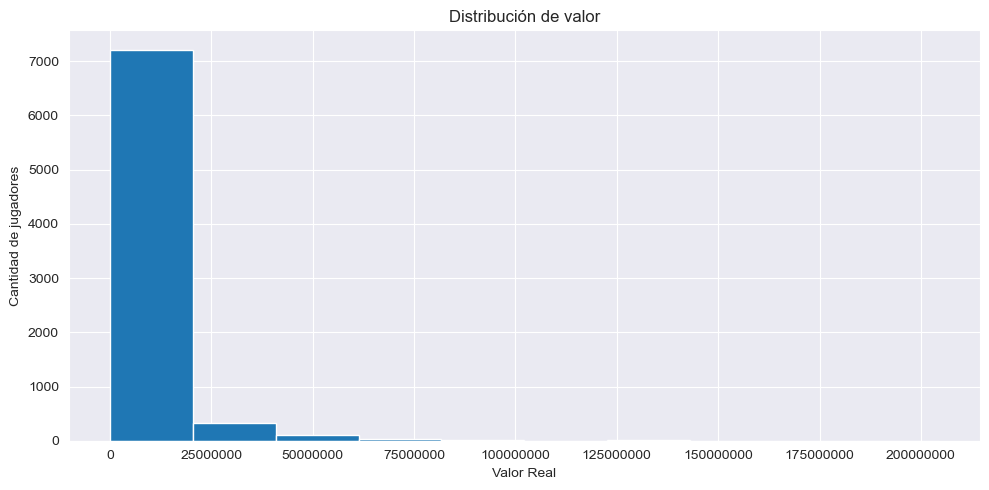

	Gráfico 2:Distribución de las posiciones de los jugadores


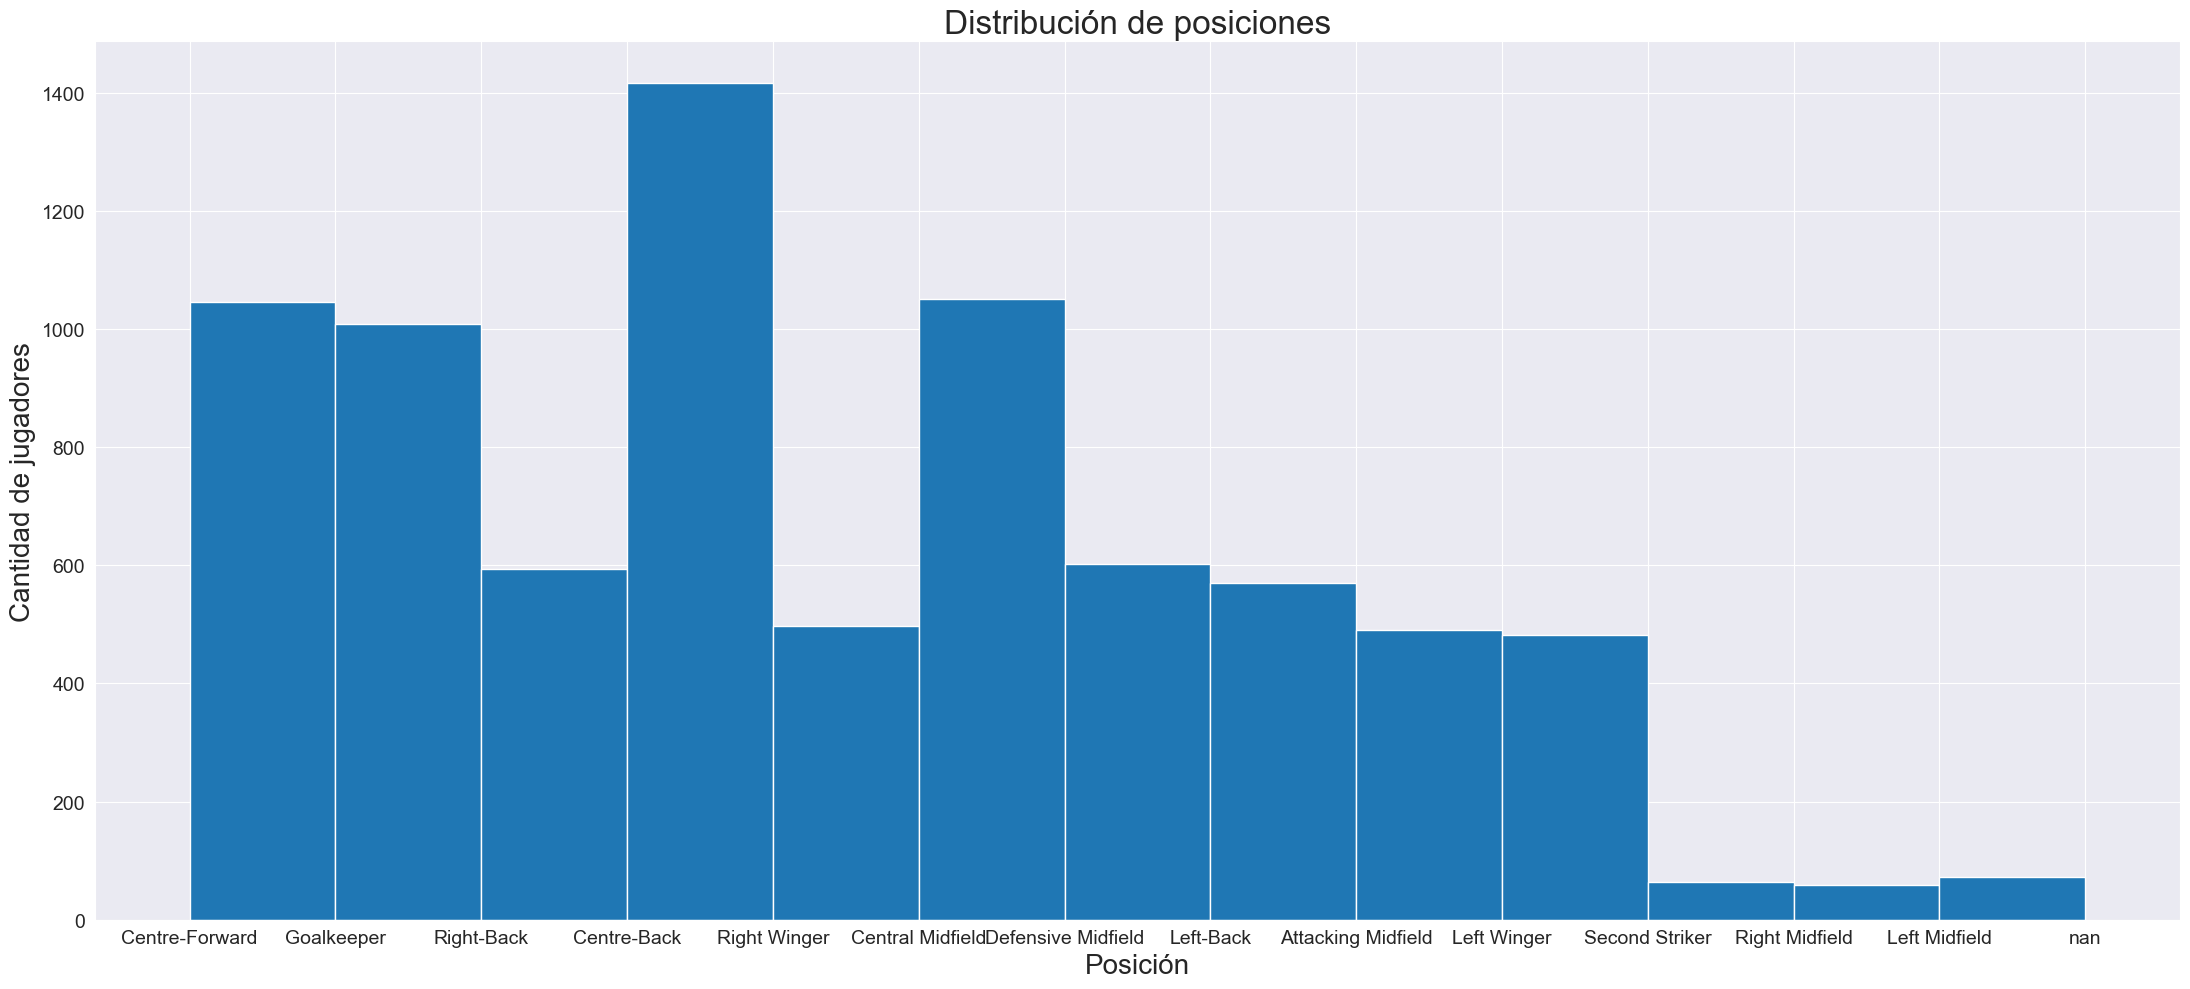

	Gráfico 3:matriz de correlaciones de variables numéricas.


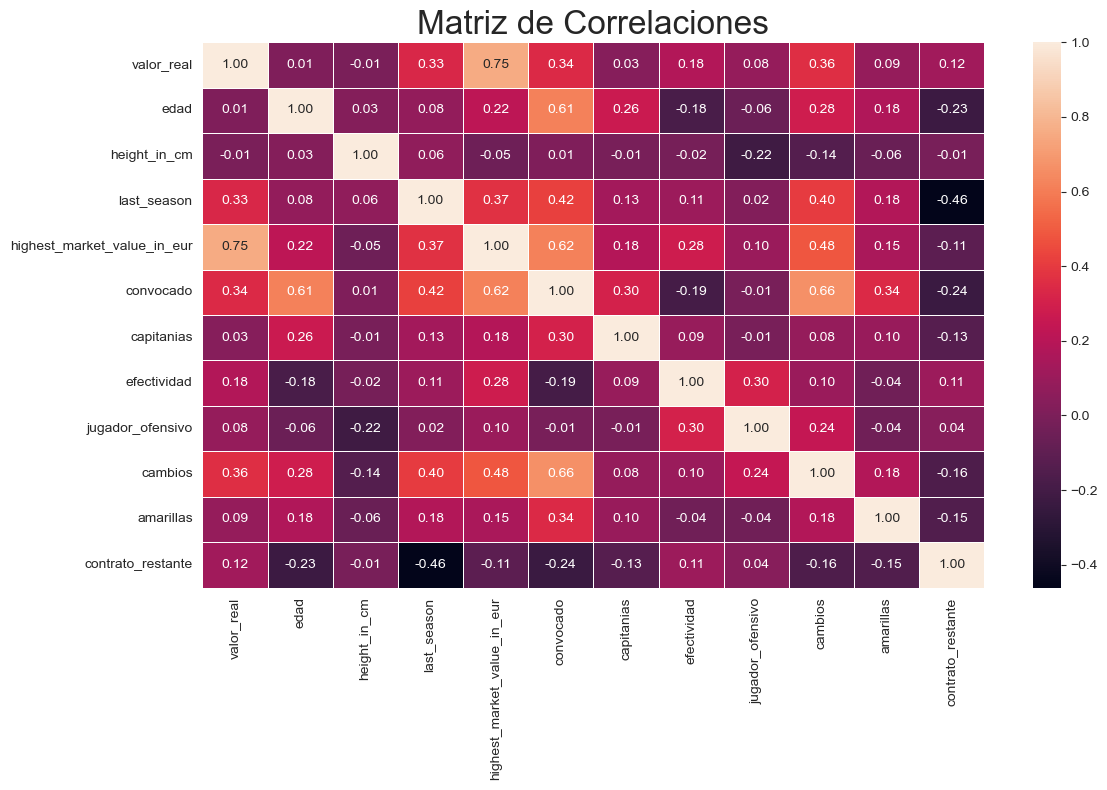

	Gráfico 4:matriz de correlaciones de valor real con variables de temporadas.


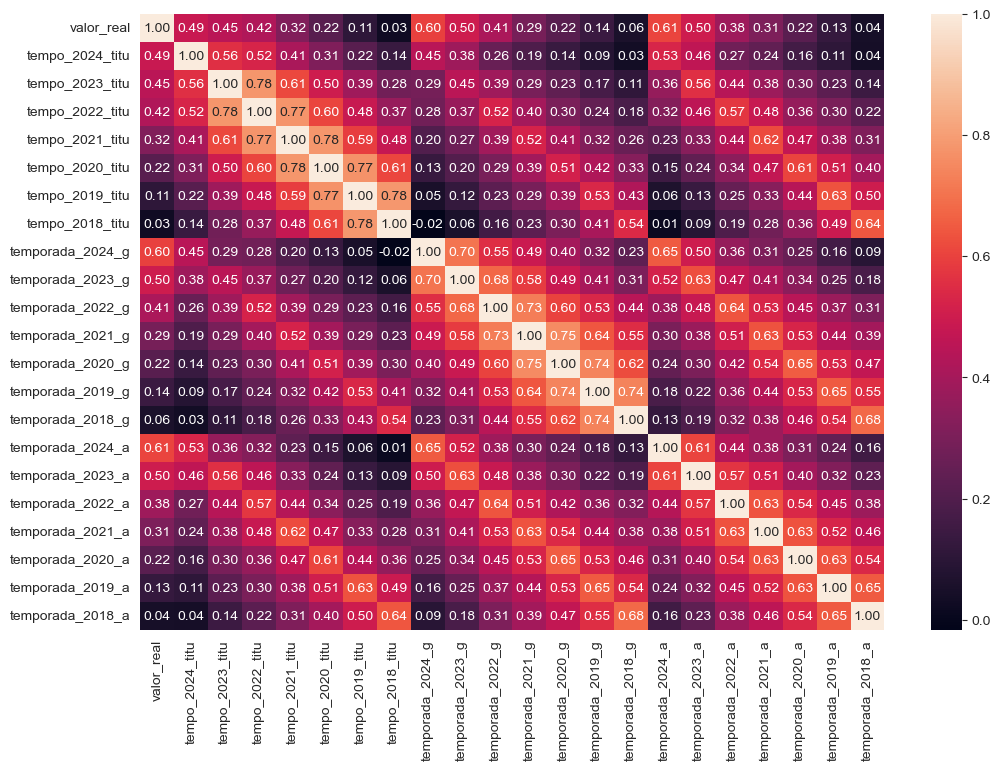

In [155]:
#Graficos

print('\tGráfico 1:Distribución del valor real de los jugadores')
plt.figure(figsize=(10, 5))
plt.hist(df_final["valor_real"])
plt.ticklabel_format(style='plain', axis='x')
plt.title("Distribución de valor")
plt.xlabel("Valor Real")
plt.ylabel("Cantidad de jugadores")
plt.tight_layout()
plt.show()

print(f'\tGráfico 2:Distribución de las posiciones de los jugadores')
plt.figure(figsize=(22, 10))
plt.hist(df_final["sub_position"].astype(str), bins=13)
plt.title("Distribución de posiciones", fontsize=24)
plt.xlabel("Posición", fontsize=20)
plt.ylabel("Cantidad de jugadores", fontsize=20)
plt.xticks(fontsize=14)#cambian el tamaño de valores sobre el eje de x e y
plt.yticks(fontsize=14)
plt.tight_layout()#para que no se superpongan
plt.show()

print(f'\tGráfico 3:matriz de correlaciones de variables numéricas.')
corr_c = df_final[["valor_real", "edad", "height_in_cm", "last_season","highest_market_value_in_eur", "convocado","capitanias", "efectividad", "jugador_ofensivo","cambios","amarillas","contrato_restante"]].corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_c, annot=True, linewidths=.5, fmt=".2f")
plt.title("Matriz de Correlaciones", fontsize=24)
plt.tight_layout()
plt.show()

print(f'\tGráfico 4:matriz de correlaciones de valor real con variables de temporadas.')
corr_tempo=df_final[["valor_real","tempo_2024_titu","tempo_2023_titu","tempo_2022_titu","tempo_2021_titu","tempo_2020_titu","tempo_2019_titu","tempo_2018_titu","temporada_2024_g","temporada_2023_g","temporada_2022_g","temporada_2021_g","temporada_2020_g","temporada_2019_g","temporada_2018_g","temporada_2024_a","temporada_2023_a","temporada_2022_a","temporada_2021_a","temporada_2020_a","temporada_2019_a","temporada_2018_a"]].corr()
f, ax=plt.subplots(figsize=(12,8))
sns.heatmap(corr_tempo,annot=True,fmt=".2f")
plt.show()
#OUTLIERS
q1 = df_final["valor_real"].quantile(0.25)
q3 = df_final["valor_real"].quantile(0.75)
iqr = q3 - q1
lim_sup = q3 + 3 * iqr
lim_inf = q1 - 3 * iqr
df_final=df_final[(df_final["valor_real"]<=lim_sup)&(df_final["valor_real"]>=lim_inf)]

In [156]:
#ELIMINO faltantes y columnas que no voy a usar
df_final = df_final.dropna(subset=["height_in_cm","valor_real"])
df_final = df_final.drop(["current_club_name", "player_code", "image_url", "city_of_birth", "url","first_name","contract_expiration_date","date_of_birth","inf_acum","last_name","name","player_id","position","market_value_in_eur","temporada_borrar","country_of_birth"], axis=1)

#CORRECCIONES finales
df_final["current_club_id"]=df_final["current_club_id"].astype(str)


In [157]:
df_final

,last_season,current_club_id,country_of_citizenship,sub_position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,highest_market_value_in_eur,valor_real,edad,contrato_restante,convocado,tempo_2018_titu,tempo_2019_titu,tempo_2020_titu,tempo_2021_titu,tempo_2022_titu,tempo_2023_titu,tempo_2024_titu,capitanias,temporada_2018_g,temporada_2019_g,temporada_2020_g,temporada_2021_g,temporada_2022_g,temporada_2023_g,temporada_2024_g,goles,asistencias,cambios,amarillas,club_id,stadium_seats,temporada_2018_a,temporada_2019_a,temporada_2020_a,temporada_2021_a,temporada_2022_a,temporada_2023_a,temporada_2024_a,jerarquia_rondas_CL,jerarquia_rondas_EL,jugador_ofensivo,efectividad
0,2019,86,Peru,Centre-Forward,right,184.0,NaN,L1,12000000.0,488511.727045,40.0,NaN,80.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,6.0,0.0,0.0,0.0,0.0,0.0,10.0,3.0,5.0,NaN,86,42100,3.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,0.1625
1,2019,127,Germany,Goalkeeper,right,188.0,NaN,L1,1000000.0,61063.965881,36.0,NaN,11.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,2019,162,Switzerland,Goalkeeper,right,194.0,KBM,FR1,11500000.0,305319.829403,35.0,NaN,53.0,22.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162,18525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
5,2018,4,Germany,Goalkeeper,right,184.0,NaN,L1,1250000.0,62095.482609,34.0,NaN,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
6,2019,38,Germany,Goalkeeper,right,190.0,Sports360 GmbH,L1,4500000.0,366383.795284,34.0,NaN,48.0,18.0,15.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,38,54600,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7935,2024,3911,Mali,Defensive Midfield,right,164.0,BLACKSKILL,FR1,NaN,204369.948139,17.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3911,15220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
7942,2024,417,Nigeria,Centre-Forward,right,194.0,Maître Ted DIMVULA,FR1,NaN,510924.870348,17.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,417,36178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
7945,2023,3524,Cote d'Ivoire,Centre-Back,right,174.0,BLACKSKILL,FR1,NaN,54047.837707,17.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3524,10800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
7947,2024,35,The Gambia,Centre-Forward,NaN,185.0,David Moss Group,L1,NaN,510924.870348,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,3.0,NaN,35,29546,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,1,NaN


In [158]:
df_final.to_csv("df_final2.csv",index=False)